<a href="https://colab.research.google.com/github/IrisFDTD/AI-UNIZAR-course/blob/main/ode/ai_unizar_course_ode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">*Introducción a la inteligencia artificial: redes neuronales avanzadas con Tensorflow-Keras*</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Sergio Gutiérrez Rodrigo (sergut@unizar.es)</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Licencia Creative Commons Atribución-NoComercial-CompartirIgual 4.0 Internacional</a>.

```
Sergio G Rodrigo
Departamento de Física Aplicada
Universidad de Zaragoza
Instituto de Nanociencia y Materiales de Aragón (INMA)
C/ Pedro Cerbuna, 12, 50009, Zaragoza, España
```






# **Advanced Neural Networks with TensorFlow-Keras**

---
#**Solving Ordinary Differential Equations with neural networks**
---
**Learn more about**: https://github.com/IrisFDTD/PINNs-for-education

# Main libraries

In [1]:
# Tensorflow Keras and rest of the packages
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow-Keras Model from scratch

In [2]:
class Model_from_scratch(tf.keras.Model):
    def train_step(self, data):
        # Training points and the analytical (exact) solution at this points
        x, y_exact = data
        # Calculate the gradients and update weights and bias
        with tf.GradientTape() as tape:
            y_NN  = self(x, training=True)
            loss=self.compiled_loss(y_exact,y_NN)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(y_exact, y_NN)
        return {m.name: m.result() for m in self.metrics}

#  Tensorflow-Keras Model for Ordinary Differential Equations

## Example: 1st order Ordinary Differential Equation
$y'(x)+y(x)=0 \hspace{0.3cm} with \hspace{0.3cm} 0 < x < 4 $
            
$y(0)=1$

*solution:  $y(x)=\exp(-x)$*


In [3]:
class Model_ODE(tf.keras.Model):
    def train_step(self, data):
        # Training points and the analytical (exact) solution at this points
        x, y_exact = data
        # Initial conditions for the ODE-NN
        x0=tf.constant([0.0], dtype=tf.float32)
        y0_exact=tf.constant([1.0], dtype=tf.float32)
        # Calculate the gradients and update weights and bias
        with tf.GradientTape() as tape:
            # Calculate the gradients dy/dx
            with tf.GradientTape() as tape2:
              tape2.watch(x0)
              tape2.watch(x)
              y0_NN = self(x0, training=True)
              y_NN  = self(x, training=True)
            dy_dx_NN= tape2.gradient(y_NN,x)
            #Loss= ODE+ boundary/initial conditions
            loss=self.compiled_loss(dy_dx_NN, -y_NN)\
                +self.compiled_loss(y0_NN,y0_exact)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(y_exact, y_NN)
        return {m.name: m.result() for m in self.metrics}

## Training data

Function $y(x)=exp(-x)$, trained in the range $x \in [0,x_{max}]$.

In [4]:
n_train = 20
xmin = 0
xmax = 4

# Definition of the function domain
x_train=np.linspace(xmin,xmax,n_train)

# The real solution y(x) for training evaluation
y_train=tf.exp(-x_train)

# Hyperparameters

In [5]:
# Hiperparameters
epochs = 100
lr=0.001

# Define the Tensorflow-Keras model

+ **Regression**--> use *Model()* or *Model_from_scratch()*
+ **ODE**: use *Model_ODE()*

In [6]:
# Define the Keras layers
input=Input(shape=(1,))
x=Dense(50, activation='elu')(input)
x=Dense(50, activation='elu')(x)
output = Dense(1,activation=None)(x)

# Set the model
model=Model(input,output)
#model=Model_from_scratch(input,output)
#model=Model_ODE(input,output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2701 (10.55 KB)
Trainable params: 2701 (10.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Metrics, optimizer and loss

In [7]:
# Definition of the metrics, optimizer and loss
loss= tf.keras.losses.MeanSquaredError()
metrics=tf.keras.metrics.MeanSquaredError()
optimizer= Adam(learning_rate=lr)

model.compile(loss=loss,
          optimizer=optimizer,
          metrics=[metrics])

# Run the model

In [ ]:
history=model.fit(x_train, y_train,batch_size=1,epochs=epochs)

##  Evolution of losses during training

In [13]:
loss_vs_epochs,metrics_vs_epochs=history.history.keys()
print(loss_vs_epochs,metrics_vs_epochs)

loss mean_squared_error


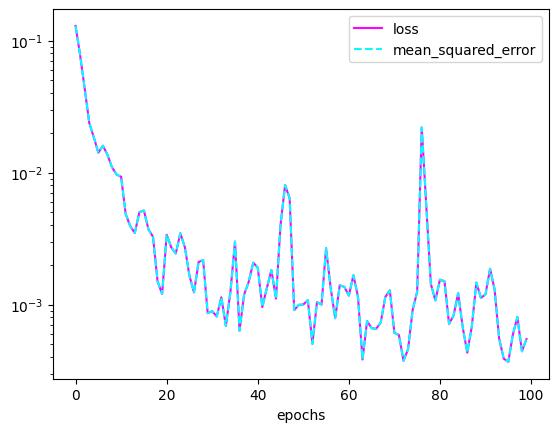

In [16]:
# summarize history for loss and metris
plt.rcParams['figure.dpi'] = 100
plt.plot(history.history[loss_vs_epochs],
         color='magenta',
         label=loss_vs_epochs)
plt.plot(history.history[metrics_vs_epochs],
         color='cyan',
         label=metrics_vs_epochs,linestyle='--')
plt.yscale("log")
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

# Validation: $y(x)$ vs $y_{NN}(x)$ and its derivatives

## A function to calculate the gradients using a Keras model

In [17]:
def get_gradients(model,x):
  '''
  The gradients y'(x) and y''(x) from the model
  '''
  x = tf.convert_to_tensor(x, dtype=tf.float32)
  with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    with tf.GradientTape(persistent=True) as t2:
          t2.watch(x)
          y = model(x)
    dy_dx = t2.gradient(y,x)
  d2y_dx2 = t.gradient(dy_dx,x)
  return dy_dx,d2y_dx2

## Plot the results

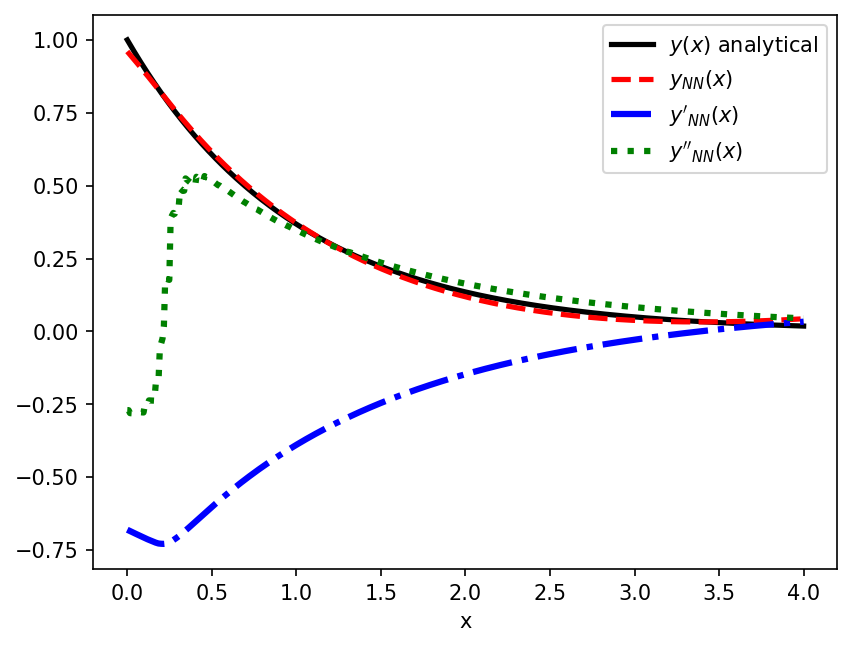

In [18]:
# Check the ODE-NN at different points not included in the training set
n = 500
x=np.linspace(0,4,n)
y_exact=tf.exp(-x)
y_NN=model.predict(x,verbose=0)

dy_dx_NN,d2y_dx2_NN=get_gradients(model,x)

# Plot the results
plt.rcParams['figure.dpi'] = 150
plt.plot(x, y_exact, color="black",linestyle='solid',
                     linewidth=2.5,label="$y(x)$ analytical")
plt.plot(x, y_NN, color="red",linestyle='dashed',
                     linewidth=2.5, label="$y_{NN}(x)$")
plt.plot(x, dy_dx_NN, color="blue",linestyle='-.',
                     linewidth=3.0, label="$y'_{NN}(x)$")
plt.plot(x, d2y_dx2_NN, color="green", linestyle='dotted',
                     linewidth=3.0, label="$y''_{NN}(x)$")
plt.legend()
plt.xlabel("x")
plt.show()